# Notebook 3 : Intelligibilité du modèle

L'intelligibilité est la capacité à expliquer ou à présenter en des termes compréhensibles
par un humain. Ce notebook vise donc à comprendre l'impact des différentes features sur les prédictions effectuées par le modèle.  
Il peut permettre de mieux comprendre les décisions prises par le modèle par rapport au poids des différentes features qu'il a utilisé ainsi que la justification de ces prédictions. Il peut aussi aider à détecter d'éventuelles erreurs permettant un meilleur ajustement du modèle à postériori.

### Import des dépendances

In [10]:
import warnings
warnings.filterwarnings('ignore')

import sys
import yaml
sys.path.append("/home/julien/Bureau/Projets/Projet 1/productsubscription_dc_cl_js")
# Attention, veuillez modifier le sys.path si vous souhaitez exécuter ce notebook

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

from subscription_forecast.domain import model_evaluation
from subscription_forecast.domain.model_evaluation import ModelEvaluator
from subscription_forecast.domain import feature_engineering
from subscription_forecast.infrastructure import preprocessing

from dtreeviz.trees import dtreeviz
from treeinterpreter import treeinterpreter as ti

from explain_utilities import plot_features_importance
from explain_utilities import plot_observation_contribution

In [12]:
config_path ="../config/config.yml"

with open(config_path, 'r') as file_in:
    CONFIG = yaml.safe_load(file_in)
    
TARGET = CONFIG['filters']['TARGET']
features_to_drop = CONFIG['filters']['features_to_drop']

### Préparation et échantillonage du dataset

In [13]:
client_full = preprocessing.features_from(CONFIG['training_data']['data_path'],
                                          CONFIG['training_data']['client_file_name'],
                                          CONFIG['training_data']['socio_eco_file_name'],
                                          features_to_drop)

In [14]:
features_to_indicator = CONFIG['filters']['features_to_indicator']
socio_eco_features = CONFIG['filters']['socio_eco_features']
numeric_features = CONFIG['filters']['numeric_features']
categorical_features = CONFIG['filters']['categorical_features']

In [15]:
y = client_full[TARGET]
y = y.replace({'Yes': 1, 'No': 0})
x = client_full.drop(columns=TARGET)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

### Création du ColumnTransformer pour process le dataset

In [16]:
transformer = ColumnTransformer(
    transformers=[('feature_indicator', feature_engineering.IndicatorTransformer(), features_to_indicator),
                  ('age_transformer', feature_engineering.age_transformer, ['age']),
                  ('date_transformer', feature_engineering.DateTransformer(), ['date']),
                  ('numeric_scaler', RobustScaler(), numeric_features),
                  ('category_transformer', feature_engineering.categorical_transformer, categorical_features),
                  ('socio_eco_scaler', RobustScaler(), socio_eco_features),
                  ('housing_perso_loan_transformer', feature_engineering.HousingPersoLoanTransformer(), ['has_housing_loan', 'has_perso_loan']),
                  ('day_last_contact_transformer', feature_engineering.day_last_contact_transformer, ['nb_day_last_contact'])
                  ],
    remainder='drop'
)

### Création du modèle et entrainement via une custom Pipeline

In [17]:
final_pipeline = Pipeline(steps=[
        ('transformer', transformer),
        ('rf', RandomForestClassifier(random_state=12, n_estimators=100, max_depth=8))])

final_pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('feature_indicator',
                                                  IndicatorTransformer(),
                                                  ['result_last_campaign']),
                                                 ('age_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('age_imputer',
                                                                   AgeImputer()),
                                                                  ('age_scaler',
                                                                   RobustScaler(copy=True,
                                                               

In [18]:
x_train_transformed = transformer.transform(x_train)
x_train_transformed = pd.DataFrame(data=x_train_transformed, columns=['result_last_campaign', 'age', 'month', 'balance', 'nb_contact', 'education_is_primaire', 'education_is_secondaire', 'education_is_tertiaire', 'status_is_divorcé', 'status_is_marié', 'status_is_celibataire', 'employment_variation_rate', 'idx_consumer_price', 'idx_consumer_confidence', 'has_loan', 'nb_day_last_contact'])
x_train_transformed.index = x_train.index 

x_test_transformed = transformer.transform(x_test)
x_test_transformed = pd.DataFrame(data=x_test_transformed, columns=['result_last_campaign', 'age', 'month', 'balance', 'nb_contact', 'education_is_primaire', 'education_is_secondaire', 'education_is_tertiaire', 'status_is_divorcé', 'status_is_marié', 'status_is_celibataire', 'employment_variation_rate', 'idx_consumer_price', 'idx_consumer_confidence', 'has_loan', 'nb_day_last_contact'])
x_test_transformed.index = x_test.index 

In [19]:
x_train = pd.DataFrame(x_train, columns=['result_last_campaign', 'age', 'month', 'balance', 'nb_contact', 'education_is_primaire', 'education_is_secondaire', 'education_is_tertiaire', 'status_is_divorcé', 'status_is_marié', 'status_is_celibataire', 'employment_variation_rate', 'idx_consumer_price', 'idx_consumer_confidence', 'has_loan', 'nb_day_last_contact']) 
model = final_pipeline[-1]

## 1. Importance features

Dans un premier temps, nous nous intéressons à l'importance des features, c'est à dire aux mesures d'importance des variables spécifiques au modèle. Différentes approches ont été développées pour extraire les importances des features. Nous présentons ci-dessous le Mean Decrease Impurty Importance (MDI) et le Mean Decrease Accuracy Importance (MDA ou Permutation Importance).

Le MDI interprète l'importance d'une feature comme la diminution de l'impureté associée à cette variable. Elle se base donc sur la fonction de coût utilisée pour déterminer les splits dans un modèle à arbres et elle est réservée aux modèles par arbres. Le MDA repose sur une autre approche. Pour une feature donnée, nous nous intéressons à la baisse de la performance du modèle si nous enlevons cette variable du modèle (c.à.d un modèle avec une fetaure en moins).

Les résultats des deux approches sont cohérentes entre elles ainsi qu'aux conclusions de l'analyse statistiques de données. Parmi les features les plus importantes, nous retrouvons aussi bien pour le MDI que le MDA :

- result_last_campaign
- idx_consumer_confidence
- employment_variation_rate
- month
- idx_consumer_price
- nb_day_last_contact

L'importance de la première feature 'result_last_campaign' est extrêmement marquée pour les deux approches, et plus particulièrement pour le MDA.

### 1.1 Mean Decrease Impurity Importance (MDI)

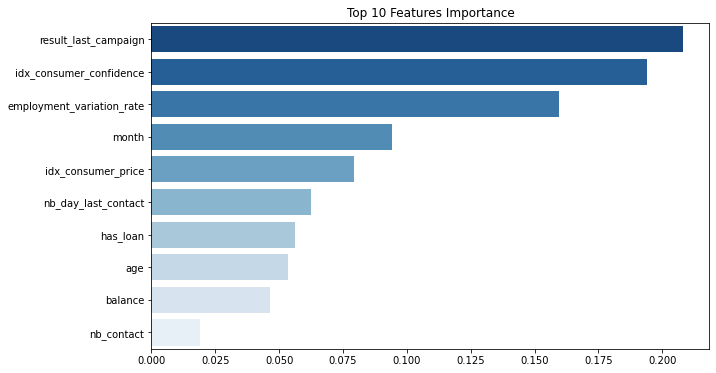

In [20]:
plot_features_importance(data=x_train, importances=model.feature_importances_, n_feat=10)

### 1.2 Permutation-based importance (MDA)

In [21]:
from eli5.sklearn.permutation_importance import PermutationImportance

def scorer(model, *args, **kwargs):
    return model.score(*args, **kwargs)

PermImp = PermutationImportance(model, scoring=scorer, n_iter=20, random_state=42, cv='prefit', refit=False)

In [22]:
PermImp.fit(x_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=8,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fract

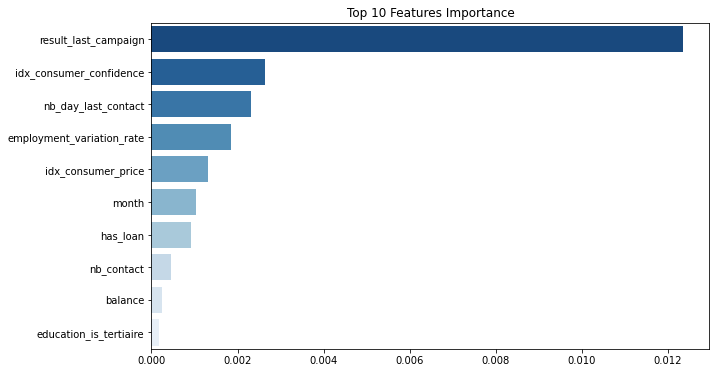

In [23]:
plot_features_importance(data=x_test_transformed, importances=PermImp.feature_importances_, n_feat=10)

## 2. Tree Interpreter

Le Tree Interpreter introduit la notion de contribution de features pour expliquer l'impact spécifique des variables.
Plus précisement, les contributions de Tree Interpreter se définissent comme les différences des prédictions entre deux noeuds ensuite attribuées à la feature utilisée dans chaque noeud.

Les contributions sont calculées localement, c'est à dire pour une observation donnée. La valeur de la prédiction est décomposée en contributions associées à chaque feature ; si une feature n'intervient pas, sa contribution sera nulle. Pour une forêt aléatoire, les contributions correspondent aux moyennes des contributions obtenues pour chaque arbre.

Afin d'obtenir une feature importance au sens global, nous pouvons moyenner les contributions sur l'ensemble des observations.

Le graphique suivant présente les feature importances au sens global. Comme pour le MDI et le MDA, nous remarquons une très forte importance dans les features 'result_last_campaign' et 'idx_consumer_confidence'. En revanche, nous remarquons ici une explosion du score pour la feature 'employment_variation_rate' et une distribution un peu plus marquée pour certaines features qui étaient jusque-là plus ou moins effacées dans les autres méthodes d'interprétation de l'explicabilité des features.

In [24]:
predictions, bias, contributions = ti.predict(model, x_test_transformed)

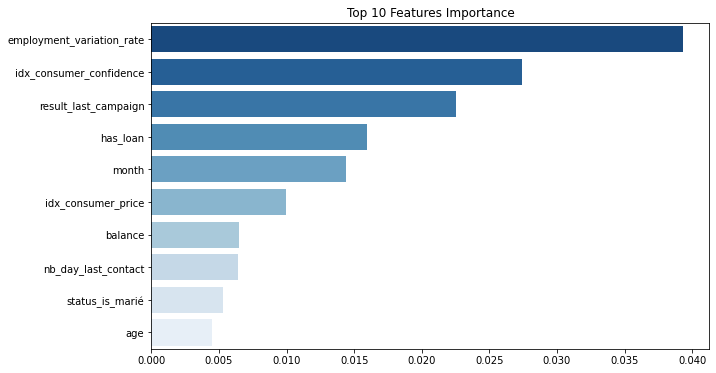

In [25]:
tree_interpreter_importances = np.abs(contributions[:, :, 1]).mean(axis=0)
plot_features_importance(data=x_test_transformed, importances=tree_interpreter_importances, n_feat=10)

## 3. Partial Dependance Plots (PDP curves)

Le graphique de dépendance partielle (PDP) montre l’effet marginal d’une variable sur la prédiction d’un classifieur. Il permet d’identifier à la  fois  le  sens  (positif ou  négatif)  et  la  forme  (linéaire,  non linéaire,  par  paliers)  de  la  relation que peut avoir la feature avec la prédiction.  
En d’autres termes, il  traduit  l’impact d’une  variable  à  différents  stades  des  valeurs  qu’elle  peut  prendre  en moyennant l’influence de tous les autres descripteurs. En analysant les features prédominantes dans les graphiques montrés précédemment, nous remarquons que les features socio-économiques comme "employment_variation_rate" et 'idx_consumer_confidence' ont une forte influence sur le modèle, contrairement à 'idx_consumer_price' qui n'a qu'une faible influence sur la prédiction du classifieur.  
Nous pouvons aussi remarquer la forte influence de 'result_last_campaign' sur le modèle, et étant un booléen nous voyons que sa courbe est une droite croissante de 0 à 1, signifiant qu'il a une influence positive sur le modèle.

In [26]:
from pdpbox import pdp

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


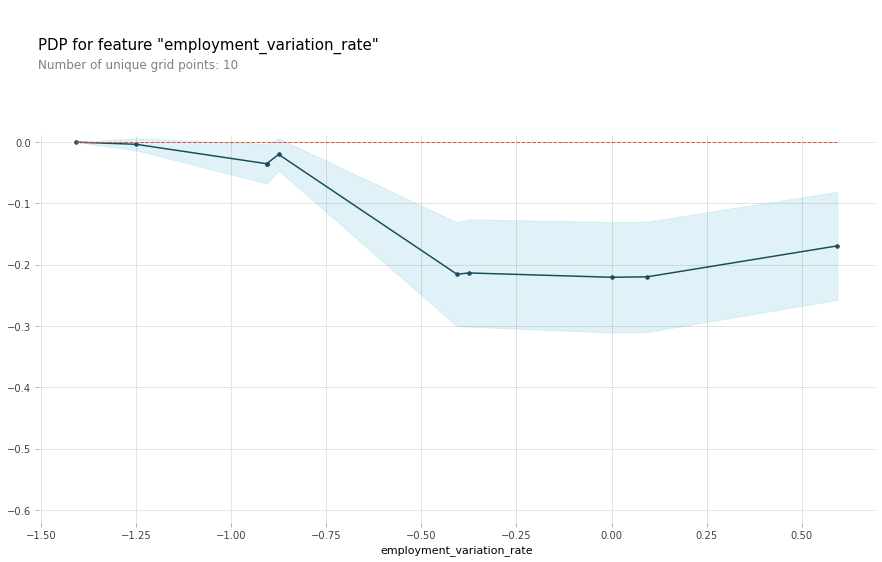

In [27]:
variable = 'employment_variation_rate' 

one_hot_columns = [c for c in x_test_transformed.columns if c.startswith(variable)]
feature = variable if len(one_hot_columns) == 1 else one_hot_columns

pdp_goals = pdp.pdp_isolate(model=model,
                            dataset=x_test_transformed,
                            model_features=x_test_transformed.columns,
                            feature=feature,
                            num_grid_points=20,
                            grid_type='percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True)
plt.show()

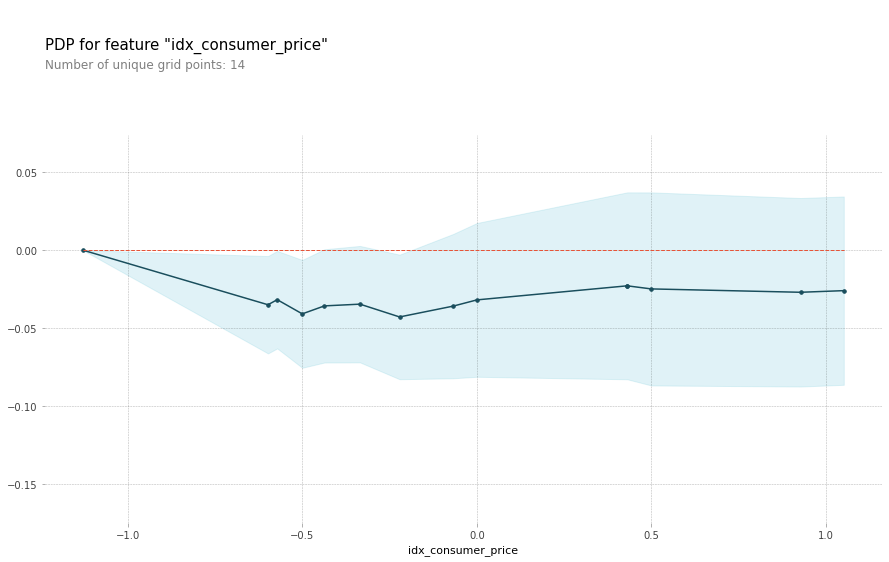

In [28]:
variable = 'idx_consumer_price' 

one_hot_columns = [c for c in x_test_transformed.columns if c.startswith(variable)]
feature = variable if len(one_hot_columns) == 1 else one_hot_columns

pdp_goals = pdp.pdp_isolate(model=model,
                            dataset=x_test_transformed,
                            model_features=x_test_transformed.columns,
                            feature=feature,
                            num_grid_points=20,
                            grid_type='percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True)
plt.show()

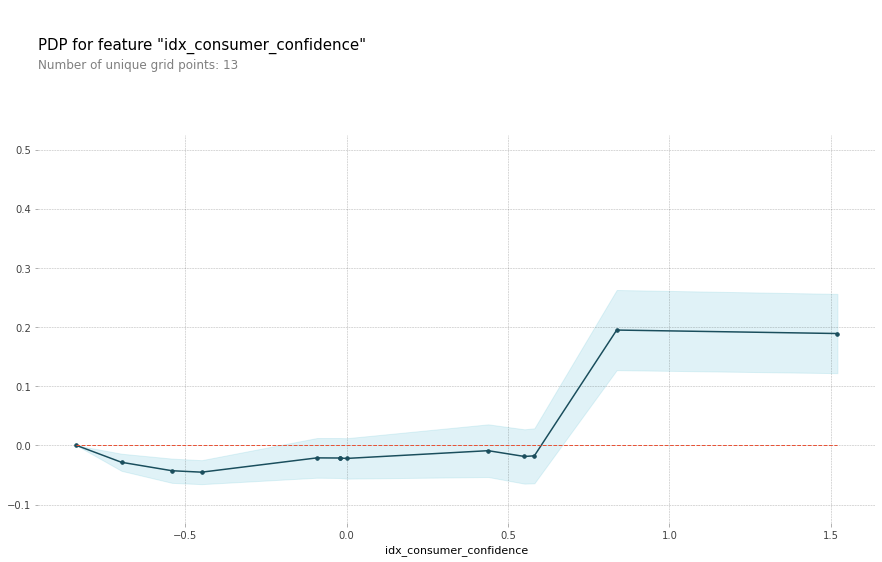

In [29]:
variable = 'idx_consumer_confidence' 

one_hot_columns = [c for c in x_test_transformed.columns if c.startswith(variable)]
feature = variable if len(one_hot_columns) == 1 else one_hot_columns

pdp_goals = pdp.pdp_isolate(model=model,
                            dataset=x_test_transformed,
                            model_features=x_test_transformed.columns,
                            feature=feature,
                            num_grid_points=20,
                            grid_type='percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True)
plt.show()

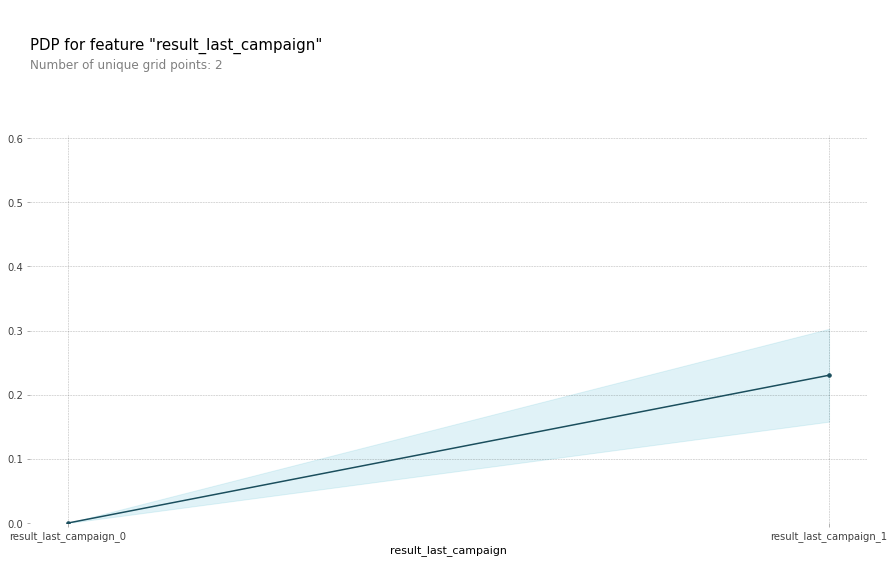

In [30]:
variable = 'result_last_campaign' 

one_hot_columns = [c for c in x_test_transformed.columns if c.startswith(variable)]
feature = variable if len(one_hot_columns) == 1 else one_hot_columns

pdp_goals = pdp.pdp_isolate(model=model,
                            dataset=x_test_transformed,
                            model_features=x_test_transformed.columns,
                            feature=feature,
                            num_grid_points=20,
                            grid_type='percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True)
plt.show()